In [9]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from skimage.util import view_as_windows

from skimage.measure import block_reduce
from framework.dftloss import *
# ---------- Load MNIST data and split ----------
(x_train, y_train), (x_test,y_test) = cifar10.load_data()
# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')
x_test = np.asarray(x_test,dtype='float32')
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')
print("training with input:", x_train.shape)


training with input: (50000, 32, 32, 3)


In [5]:
def HAAR_Transform(Xinput, steps = 1):

    featuremaps = []
    featmap = Xinput
    curstep = 0
    while curstep < steps:
        
        print("_____________in step :", curstep, '_______________')
        print("input feature map:", featmap.shape)
        curstep += 1
        win = 2
        stride = 1
        X = view_as_windows(featmap, (1, win, win, 1), (1, stride, stride, 1))
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3],-1)
        
        # print("shape for HAAR input:", X.shape)
        p0 = X[:,:,:,:,0]
        p1 = X[:,:,:,:,1]
        p2 = X[:,:,:,:,2]
        p3 = X[:,:,:,:,3]

        b0 = (p0 + p1) + (p2 + p3) #DC level
        b1 = (p0 - p1) + (p2 - p3) #'Horizontal difference
        b2 = (p0 + p1) - (p2 + p3) #'Vertical difference
        b3 = (p0 - p1) - (p2 - p3) #'Horizontal and vertical difference
        
        feattmp = np.concatenate((b0, b1, b2, b3), axis = -1 )
        feattmp = MaxPooling(feattmp)
        print("transformed shape for current step:", feattmp.shape)
        featuremaps.append(feattmp)
        
        featmap = feattmp[:,:,:,:3]
    
    return featuremaps
       

def MaxPooling(x,step=2):
    if len(x.shape)<4:
        return block_reduce(x, (1, step, step), np.max)
    else:
        return block_reduce(x, (1, step, step, 1), np.max) 

In [6]:
test = HAAR_Transform(x_train[:1], 4)

for featmap in test:
    
    print(featmap.shape)

_____________in step : 0 _______________
input feature map: (1, 32, 32, 3)
transformed shape for current step: (1, 16, 16, 12)
_____________in step : 1 _______________
input feature map: (1, 16, 16, 3)
transformed shape for current step: (1, 8, 8, 12)
_____________in step : 2 _______________
input feature map: (1, 8, 8, 3)
transformed shape for current step: (1, 4, 4, 12)
_____________in step : 3 _______________
input feature map: (1, 4, 4, 3)
transformed shape for current step: (1, 2, 2, 12)
(1, 16, 16, 12)
(1, 8, 8, 12)
(1, 4, 4, 12)
(1, 2, 2, 12)


In [8]:
# DFT functions:
import numpy as np
from collections import Counter

def split_process_we(X, y, split, numclass = 2):

    leftidx = np.where(X<=split)
    rightidx = np.where(X>split)
    
    # print("check left and right:", leftidx[0].shape, rightidx[0].shape)
    return weighted_entropy_for_splitting(leftidx, rightidx, y, numclass)

def cal_entropy(prob,numclass=2):
    
    prob_tmp = np.copy(prob)
    prob_tmp[prob_tmp==0] = 1 # ignore this term
    tmp = np.sum(-1*prob*np.log(prob_tmp),axis=-1)
    return tmp/np.log10(numclass)

def entropy_with_label(yinput, numclass=2):
    
    # yinput in shape [N, C]
    # yinput = np.argmax(yinput, axis=-1)
    
    prob = np.zeros(numclass)
    samplecount = Counter(yinput)
    sampletot = yinput.shape[0]
    for i in range(numclass):
        
        prob[i] = samplecount[i]/sampletot
    
    return cal_entropy(prob, numclass = numclass)

def weighted_entropy_for_splitting(leftidx, rightidx, ynode, numclass):
    
    if leftidx[0].shape[0] == 0 or rightidx[0].shape[0] == 0:
        # invalid splitting
        return float('inf')
    
    lefty = ynode[leftidx]
    righty = ynode[rightidx]

    # use majority class as prediction target
    leftentropy = entropy_with_label(lefty, numclass = numclass)
    rightentropy = entropy_with_label(righty, numclass = numclass)
    weightedentropy = len(lefty)/len(ynode) * leftentropy + len(righty)/len(ynode) * rightentropy
    # print(len(lefty), len(righty))
    # print("left:", leftentropy, "right:", rightentropy, "weighted:", weightedentropy)
    return weightedentropy


In [51]:
# test each feature maps:
# visualization
# for idx, featmap in enumerate(test):
    
#     # print("in featmap:", idx)
#     print(featmap.shape)
#     for i in range(featmap.shape[-1]):
        
#         # print('channel:', i)
#         plt.imshow(featmap[0,:,:,i])
#         # plt.show()
#         plt.savefig('./results/hopidx_' + str(idx) + "_channel_" + str(i) + '.jpg')
#         plt.close()

in featmap: 0
(50000, 16, 16, 12)
channel: 0
channel: 1
channel: 2
channel: 3
channel: 4
channel: 5
channel: 6
channel: 7
channel: 8
channel: 9
channel: 10
channel: 11
in featmap: 1
(50000, 8, 8, 12)
channel: 0
channel: 1
channel: 2
channel: 3
channel: 4
channel: 5
channel: 6
channel: 7
channel: 8
channel: 9
channel: 10
channel: 11
in featmap: 2
(50000, 4, 4, 12)
channel: 0
channel: 1
channel: 2
channel: 3
channel: 4
channel: 5
channel: 6
channel: 7
channel: 8
channel: 9
channel: 10
channel: 11
in featmap: 3
(50000, 2, 2, 12)
channel: 0
channel: 1
channel: 2
channel: 3
channel: 4
channel: 5
channel: 6
channel: 7
channel: 8
channel: 9
channel: 10
channel: 11


In [13]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn
import cv2
Xtrain = []
for img in x_train:
    
    imgflip = cv2.flip(img,1)
    Xtrain.append(imgflip)
    
Xtrain = np.array(Xtrain)
print(Xtrain.shape)

Xtrain = np.concatenate((Xtrain,x_train),axis=0)
print(Xtrain.shape)

Ytrain = np.concatenate((y_train,y_train),axis=0)



(50000, 32, 32, 3)
(100000, 32, 32, 3)


# Input Format

## RGB ( no change )

In [ ]:
feattrain = HAAR_Transform(Xtrain, 4)
feattest = HAAR_Transform(x_test, 4)

print("train feats:")
for feat in feattrain:
    
    print(feat.shape)
    
print("test feats:")
for feat in feattest:
    
    print(feat.shape)

## PCA decomposed

In [14]:
from sklearn.decomposition import PCA

Xtrain = np.array(Xtrain)
print(Xtrain.shape)
S = Xtrain.shape
Xtrain = Xtrain.reshape((-1, 3))
pca = PCA(n_components=3, svd_solver='full')
pca.fit(Xtrain)

Xtrain_PCA = pca.transform(Xtrain)
Xtrain_PCA = Xtrain_PCA.reshape(S)
print(Xtrain_PCA.shape)



(100000, 32, 32, 3)
(100000, 32, 32, 3)


In [15]:
feattrain = HAAR_Transform(Xtrain_PCA, 4)

S = x_test.shape
x_test_pca = x_test.reshape((-1,3))
x_test_pca = pca.transform(x_test_pca)
x_test_pca = x_test_pca.reshape(S)
feattest = HAAR_Transform(x_test_pca, 4)

print("train feats:")
for feat in feattrain:
    
    print(feat.shape)
    
print("test feats:")
for feat in feattest:
    
    print(feat.shape)

_____________in step : 0 _______________
input feature map: (100000, 32, 32, 3)
transformed shape for current step: (100000, 16, 16, 12)
_____________in step : 1 _______________
input feature map: (100000, 16, 16, 3)
transformed shape for current step: (100000, 8, 8, 12)
_____________in step : 2 _______________
input feature map: (100000, 8, 8, 3)
transformed shape for current step: (100000, 4, 4, 12)
_____________in step : 3 _______________
input feature map: (100000, 4, 4, 3)
transformed shape for current step: (100000, 2, 2, 12)
_____________in step : 0 _______________
input feature map: (10000, 32, 32, 3)
transformed shape for current step: (10000, 16, 16, 12)
_____________in step : 1 _______________
input feature map: (10000, 16, 16, 3)
transformed shape for current step: (10000, 8, 8, 12)
_____________in step : 2 _______________
input feature map: (10000, 8, 8, 3)
transformed shape for current step: (10000, 4, 4, 12)
_____________in step : 3 _______________
input feature map: (10

## convert to HSV 

In [12]:
import cv2

for idx in range(Xtrain.shape[0]):
    
    # plt.imshow(Xtrain[idx]/255)
    # plt.show()
    Xtrain[idx] = cv2.cvtColor(Xtrain[idx], cv2.COLOR_RGB2HSV)
    # plt.imshow(Xtraintmp[idx]/255)
    # plt.show()
    
for idx in range(x_test.shape[0]):
    
    x_test[idx] = cv2.cvtColor(x_test[idx], cv2.COLOR_RGB2HSV)


error: OpenCV(3.4.8) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:88: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3>; VDepth = cv::impl::{anonymous}::Set<0, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [ ]:

feattrain = HAAR_Transform(Xtrain, 4)
feattest = HAAR_Transform(x_test, 4)

print("train feats:")
for feat in feattrain:
    
    print(feat.shape)
    
print("test feats:")
for feat in feattest:
    
    print(feat.shape)

# LightGBM feature evaluation

## Raw Feat

In [16]:
hopidx = 0

trainmap = feattrain[hopidx]
testmap = feattest[hopidx]

trainmap = trainmap.reshape(trainmap.shape[0], -1)
testmap = testmap.reshape(testmap.shape[0], -1)

print(trainmap.shape, testmap.shape)

(100000, 3072) (10000, 3072)


## DFT

In [18]:
# from framework.DFT import *
from tqdm import tqdm

K_for_split = 32 # try less than 128
num_classes = 10
nSamples = trainmap.shape[0]

lossrecord = []
lossDR = []
# train_target = train_target.reshape(train_target.shape[0])
# y = Ytrain.reshape(Ytrain.shape[0])
# y = Ytrain.astype("float64")
y = Ytrain.reshape(Ytrain.shape[0], 1)
y = y.astype("float64")

print(y.shape)

for featidx in tqdm(range(trainmap.shape[-1])):
# for featidx in range(2):
    
    X = trainmap[:,featidx]
    # X = X.reshape(X.shape)
    # X = np.squeeze(testfeat[:,featidx], axis = 1)
    X = X.astype('float64')

    splits = np.linspace(X.min(), X.max(), K_for_split)
    losstmp = []
    losstmp1 = []
    for i in range(1,splits.shape[0]-1):
        
        # losscur.append(split_process_reg(Xnode, Ynode, splits[i]))
        losstmp.append(split_process_we(X , y, splits[i], numclass = num_classes))

    lossrecord.append(np.min(losstmp))
    lossDR.append(np.max(losstmp) - np.min(losstmp))

plt.plot(sorted(lossrecord))
plt.show()
    
plt.plot(sorted(lossDR))
plt.show()

  0%|          | 0/3072 [00:00<?, ?it/s]

(100000, 1)


 10%|▉         | 307/3072 [01:53<16:59,  2.71it/s]

## Compressed Feature

In [154]:
hopidx = 3
spatial = 1 # hyper parameters
featmap = feattrain[hopidx]
feat1 = featmap
S = feat1.shape
print(feat1.shape)

feat1 = block_reduce(feat1, (1, S[1]//spatial, S[2]//spatial, 1), np.max)
feat1 = feat1.reshape(S[0], -1)
print(feat1.shape)

feat2 = np.linalg.norm(featmap, ord=2, axis = -1)
feat2 = feat2.reshape((S[0], -1))
# print(feat2.shape)

feat3 = np.linalg.norm(featmap, ord=1, axis = -1)
feat3 = feat3.reshape((S[0], -1))
# print(feat3.shape)

trainmap = np.concatenate((feat1, feat2, feat3), axis= -1)
print(trainmap.shape)


featmap = feattest[hopidx]
feat1 = featmap
S = feat1.shape
print(feat1.shape)
# spatial = 2 # hyper parameters
feat1 = block_reduce(feat1, (1, S[1]//spatial, S[2]//spatial, 1), np.max)
feat1 = feat1.reshape(S[0], -1)
print(feat1.shape)


feat2 = np.linalg.norm(featmap, ord=2, axis = -1)
feat2 = feat2.reshape((S[0], -1))
# print(feat2.shape)

feat3 = np.linalg.norm(featmap, ord=1, axis = -1)
feat3 = feat3.reshape((S[0], -1))
# print(feat3.shape)

testmap = np.concatenate((feat1, feat2, feat3), axis= -1)
print(testmap.shape)

(100000, 2, 2, 12)
(100000, 12)
(100000, 20)
(10000, 2, 2, 12)
(10000, 12)
(10000, 20)


## LightGBM start

In [155]:
from sklearn.model_selection import train_test_split

X_fit, X_val, y_fit, y_val = train_test_split(
    trainmap, Ytrain, test_size=0.01, random_state=42)

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

train data: (99000, 20) (99000, 1)
val data: (1000, 20) (1000, 1)


train data: (99000, 20) (99000, 1)
val data: (1000, 20) (1000, 1)


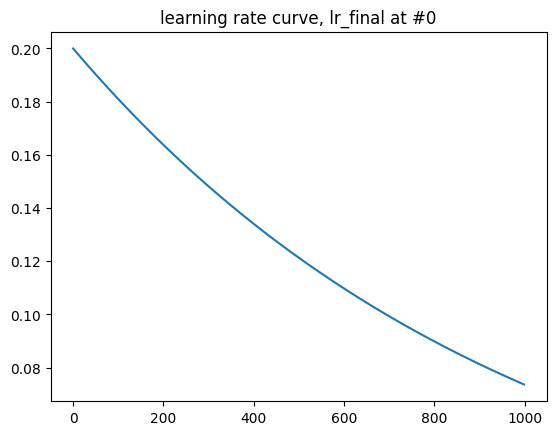

/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[100]	fit's multi_logloss: 1.4228	val's multi_logloss: 1.74767
[200]	fit's multi_logloss: 1.19063	val's multi_logloss: 1.75764
[300]	fit's multi_logloss: 1.00878	val's multi_logloss: 1.76696
[400]	fit's multi_logloss: 0.853139	val's multi_logloss: 1.7839
[500]	fit's multi_logloss: 0.718842	val's multi_logloss: 1.79941
[600]	fit's multi_logloss: 0.606471	val's multi_logloss: 1.81808
[700]	fit's multi_logloss: 0.509199	val's multi_logloss: 1.83307
[800]	fit's multi_logloss: 0.425801	val's multi_logloss: 1.85051
[900]	fit's multi_logloss: 0.354243	val's multi_logloss: 1.87115
[1000]	fit's multi_logloss: 0.294459	val's multi_logloss: 1.895
training time: 72.017817735672
Plot metrics recorded during training...


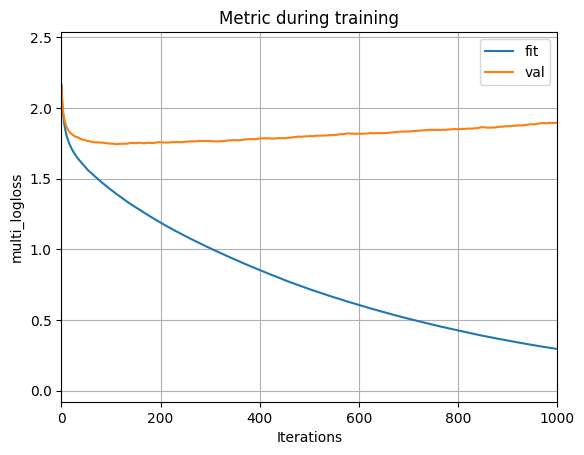

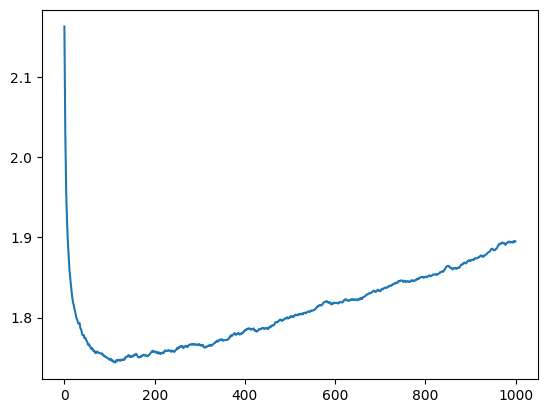

Train Accuary: 98.92%


In [156]:
import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn
import time

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

fit = lgb.Dataset(
    X_fit, y_fit,
)

val = lgb.Dataset(
    X_val, y_val,
)

maxdepth = 5
lr0 = 0.2 # make sure GD at the begining
lr_final = 0.2 # make sure final converge faster
k = -0.001 # lower -> more smooth
num_rounds = 1000
rounds = np.arange(num_rounds)
rounds_lr = lr0 * math.e**(k * rounds)
plt.plot(rounds, rounds_lr)
plt.title("learning rate curve, lr_final at #" + str(int(math.log(lr_final/lr0)/k)) )
plt.show()

evals_result = {} 

t0 = time.time()
model = lgb.train(
    params={
        'learning_rate': 0.1,
        'max_depth': maxdepth,
        # 'num_leaves': 10,
        'device' : 'gpu',
        # 'gpu_platform_id' : 0,
        # 'gpu_device_id' : 0 ,
        # 'num_gpu' : 2,
        'objective': 'multiclass',
        'num_class':10,
        # 'feature_fraction': 0.4,
        # 'bagging_fraction': 0.6,
        # 'bagging_freq': 10,
        'verbose' : -1
           },
    train_set=fit,
    num_boost_round=num_rounds,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    # early_stopping_rounds=200,
    evals_result=evals_result,
    verbose_eval=100,
    # fobj=fl.lgb_obj,
    # feval=fl.lgb_eval,
    callbacks=[lgb.reset_parameter(learning_rate=lambda \
        current_round: max(lr0 * math.e**(k * current_round), lr_final))]
)

print("training time:", time.time()-t0)
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

plt.plot(evals_result['val']['multi_logloss'])
plt.show()

y_preds =model.predict(X_fit)
y_train_preds = []
for x in y_preds:
    y_train_preds.append(np.argmax(x))

y_train_preds = np.array(y_train_preds)

train_accuracy = accuracy_score(y_fit, y_train_preds)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))


Test Accuary: 35.05%


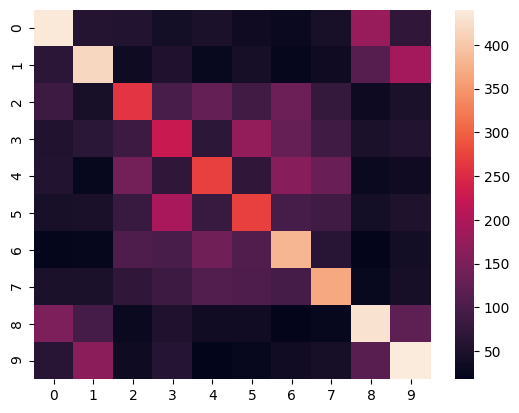

In [157]:
t0 = time.time()
y_test_preds = []
# y_preds =model.predict(feattest)
y_preds = model.predict(testmap)
for x in y_preds:
    y_test_preds.append(np.argmax(x))
y_test_preds = np.array(y_test_preds)

pred_accuracy_score = accuracy_score(y_test, y_test_preds)
# pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print("Test Accuary: %.2f%%" % (pred_accuracy_score* 100.0))
# print('inference time:', time.time() - t0)

cnf_matrix = confusion_matrix(y_test, y_test_preds)
df_cm = pd.DataFrame(cnf_matrix)
sn.heatmap(df_cm)
plt.show()